(C:denoising)=
# Denoising

In [1]:
import skimage as ski
from skimage.util import random_noise
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from myst_nb import glue

Le débruitage (_denoising_) consiste à diminuer le plus possible le bruit dans une image.
Dans la très grande majorité des cas, il n'est pas possible de supprimer complètement le bruit.

Le débruitage fait partie de la famille des méthodes de restauration (_restoration_),
au même titre que la déconvolution que l'on verra dans le {ref}`chapitre suivant <C:deconvolution>`.
La restauration consiste à supprimer (ou diminuer) les dégradations subies par l'image.
Pour appliquer une méthode de restauration, il faut avant tout définir un modèle mathématique de la dégradation.
Ensuite, seulement, on pourra « inverser » la dégradation ; on dit que la restauration est un « problème inverse ».
Très souvent, la restauration nécessite la formulation d'un critère à minimiser,
c'est-à-dire une fonction mathématique dont le minimum correspond à la meilleure restauration possible.

<!-- introduire le schéma : x -> dégradation -> y -> restauration -> \hat{x} -->
<!-- donner des exemples réels, liés à des problèmes de restauration (denoising, deconvolution, dehazing, gestion des distortions -->

Dans ce chapitre, nous commençons par lister les modèles de bruit les plus courants,
puis nous présentons quelques méthodes de débruitage.

## Sources de bruit

Les principales sources de bruit dans les images numériques interviennent
durant l'acquisition (quantité de photons collectés trop faible, température du capteur...)
ou durant l'éventuelle transmission (échos et distorsions atmosphériques en communication sans-fil).
Dans certains cas, le bruit peut également représenter les imprécisions du modèle mathématique de formation de l'image,
qui comme tout modèle physique est forcément imparfait par rapport à la réalité !

Le bruit étant par nature un phénomène aléatoire, il est modélisé par une densité de probabilité qui représente la distribution d'intensité du bruit.

Dans la suite, nous notons $y$ l'image observée (et donc bruitée), $b$ le bruit et $x$ l'image non bruitée.


### Bruit blanc gaussien additif

Le bruit blanc gaussien additif (AWGN : _additive white Gaussian noise_) modélise chaque pixel $(m,n)$ de l'observation $y$
par la somme du pixel $(m,n)$ de l'image non bruitée $x$ et d'un pixel du bruit $b$ :

$$
  \forall\, m,n \quad
  y(m,n) = x(m,n) + b(m,n)
$$

où $b(m,n) \sim \mathcal{N}(0,\,\sigma^2)$.

Ce modèle est simple et facilite les calculs.
Il est utilisé dans la plupart des applications, dont la photographie.


### Bruit de Poisson
<!-- Jahne 3.4.1 -->

Dans le cas d'un bruit de Poisson (_Poisson noise_ ou _shot noise_),
le nombre de photons mesurés par un photosite est aléatoire et dépend de l'illumination.
Il est modélisé par un processus de Poisson dont la moyenne est égale à l'illumination.
L'intensité de chaque pixel $(m,n)$ de l'observation $y$ est :

$$
  \forall\, m,n \qquad
  y(m,n) \sim \mathcal{P}\big(x(m,n)\big)
$$

Ce modèle est utilisé dans le cas d'acquisitions à faible nombre de photons, par exemple en astronomie.

Pour rappel, la loi de Poisson $\mathcal{P}\big(\lambda\big)$ s'écrit

$$
  p(k)=\frac{\lambda^k}{k\,!} e^{-\lambda}
$$

La {numref}`F:denoising:poisson-distribution` représente la loi de Poisson pour trois valeurs du paramètre $\lambda$.

```{figure} figs/poisson-distribution.png
---
height: 250px
name: F:denoising:poisson-distribution
---
Loi de Poisson pour trois valeurs de $\lambda$.
```

La moyenne et la variance de la loi de Poisson sont égales et valent $\lambda$ : elles dépendent donc du nombre de photons incidents ;
le bruit $b$ dépend de l'image non bruitée $x$.
Par ailleurs, lorsque $\lambda$ augmente, la loi de Poisson tend vers la loi normale.
Le bruit de Poisson peut donc être considéré comme un bruit blanc gaussien additif s'il y a suffisamment de photons collectés.

<!-- bruit de speckle (différent d'un bruit de poisson) -->


### Bruit impulsionnel

Le bruit impulsionnel, aussi appelé poétiquement poivre & sel, (_salt-and-pepper noise_) permet de modéliser le cas où certains pixels sont saturés ou morts
(dysfonctionnement des photosites, saturation, etc.).

$$
  \forall\, m,n \quad
  y(m,n) =
  \begin{cases}
    x_\mathrm{min}      &\text{avec une probabilité}\,p_\mathrm{min}, \\
    x_\mathrm{max}      &\text{avec une probabilité}\,p_\mathrm{max}, \\
    x(m,n)              &\text{avec une probabilité}\,1\!-\!p_\mathrm{min}\!-\!p_\mathrm{max}.
  \end{cases}
$$

où $x_\mathrm{min}$ et $x_\mathrm{max}$ sont les valeurs minimales et maximales des intensités.


### Puissance du bruit

La {numref}`F:denoising:three-noises` illustre l'effet des trois bruits précédents sur la même image.
On remarque notamment que :
* dans le cas du bruit gaussien, toute l'image est affectée de la même façon par le bruit,
* dans le cas du bruit de Poisson, les parties les plus claires sont plus bruitées que les parties sombres,
* dans le cas du bruit impulsionnel, seuls quelques pixels sont modifiés et ils sont remplacés par des pixels noirs ou blanc.

```{glue:figure} G:denoising:three-noises
:name: "F:denoising:three-noises"

Exemple de bruits de puissance sensiblement identique dans les trois images.
```

Le rapport signal-à-bruit (RSB ou SNR : _signal-to-noise ratio_) est une mesure du niveau de bruit.
Il correspond au rapport entre la puissance de l'image non bruitée sur la puissance du bruit.
On rappelle que la puissance d'une image $x$ est définie par :

$$
  P_x = \frac{1}{M \times N} \sum_{m,n} x(m,n)^2
$$

Le RSB est le plus souvent exprimé en échelle logarithmique (avec pour unité le décibel).
Sa définition mathématique est donc :

$$
  \text{RSB} = 10 \log_{10} \left( \frac{\sum_{m,n} x(m,n)^2}{\sum_{m,n} b(m,n)^2} \right)
$$

```{margin}
À ma connaissance, il n'y a pas de termes français équivalent.
```

Le _peak signal-to-noise ratio_ (PSNR) est le rapport entre la dynamique de l'image non bruitée (au carré) sur la puissance du bruit.
La dynamique est la différence entre l'intensité maximale et l'intensité minimale.
Cette définition s'applique dans le cas d'un bruit additif.
Le PSNR est donc défini par :

$$
  \text{PSNR} = 10 \log_{10} \left( \frac{\Delta x^{\;2}}{\frac{1}{M \times N} \sum_{m,n} b(m,n)^2} \right)
$$

<!-- TODO : pourquoi introduire le PSNR ? -->

La {numref}`F:denoising:snr-psnr` représente la même image bruitée avec un bruit blanc gaussien additif, à différents RSB et PSNR.
On constate que lorsque le RSB ou le PSNR augmente, alors le bruit diminue !

```{glue:figure} G:denoising:snr-psnr
:name: "F:denoising:snr-psnr"

Image bruitée à différents RSB et PSNR.
```

Image 0 : RSB = inf dB
Image 1 : RSB = 4.523 dB
Image 2 : RSB = 4.543 dB
Image 3 : RSB = 4.569 dB


/home/vincent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


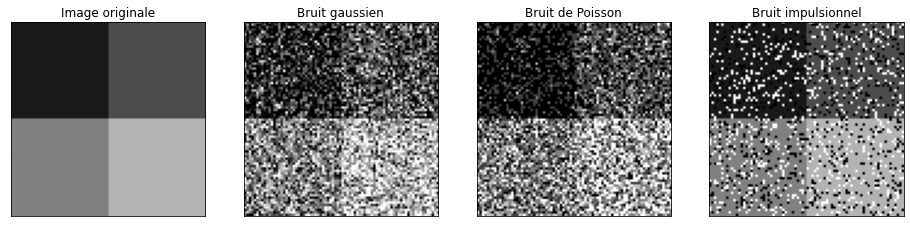

In [2]:
# Exemple de différents bruits de même RSB sur une mire

def rsb(x, y):
    Px = np.linalg.norm(x)**2
    Pb = np.linalg.norm(x-y)**2
    return 10*np.log10(Px/Pb)

# Images
N = 40
coeffs = np.array([[.1, .3], [.5, .7]])
pattern = np.ones((N,N))
x = np.kron(coeffs, pattern)
imgs = [
    x,
    random_noise(x, mode="gaussian", clip=True, mean=0, var=0.11),
    random_noise(x, mode="poisson", clip=True),
    random_noise(x, mode="s&p", clip=False, amount=.23)
]
tit = ["Image originale", "Bruit gaussien", "Bruit de Poisson", "Bruit impulsionnel"]

# Affichage
fig, ax = plt.subplots(1,4,figsize=(16,4))
for i in range(4):
    ax[i].imshow(imgs[i], cmap="gray", vmin=0, vmax=1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(tit[i])
    print(f"Image {i} : RSB = {rsb(x,imgs[i]):.3f} dB")

glue("G:denoising:three-noises", fig, display=False)

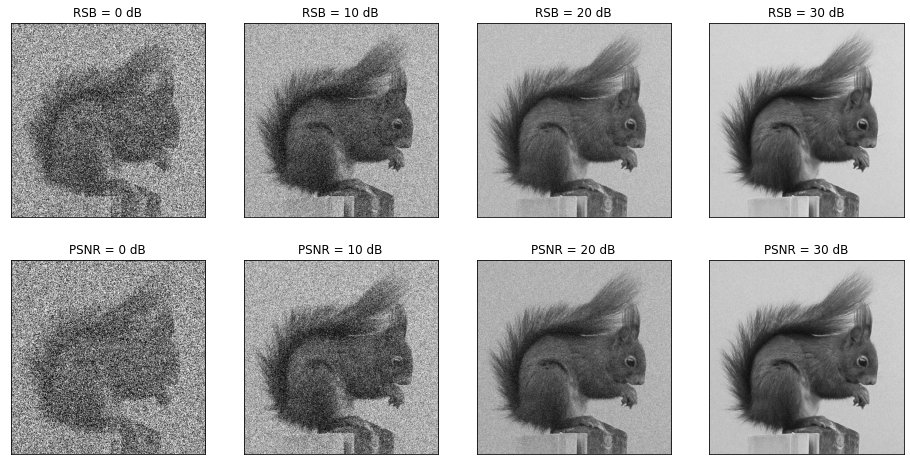

In [3]:
# La même image à différents niveaux de bruit

# Charge l'image, la convertit entre -1 et 1
x = io.imread("figs/squirrel.png")
x = ski.img_as_float(x)
# x = x - np.mean(x)

# Puissance et dynamique de l'image
(M, N) = x.shape
Px = np.linalg.norm(x)**2/(M*N)
dx = x.max() - x.min()

# Valeurs des RSB et PSNR
n = [0, 10, 20, 30]

# Tableaux
imgs = []
tit = []

# RSB
for i in range(4):
    v = Px * 10**(-n[i]/10)
    y = random_noise(x, mode="gaussian", mean=0, var=v)
    imgs.append(y)
    tit.append(f"RSB = {n[i]} dB")

# PSNR
for i in range(4):
    v = dx**2 * 10**(-n[i]/10)
    y = random_noise(x, mode="gaussian", mean=0, var=v)
    imgs.append(y)
    tit.append(f"PSNR = {n[i]} dB")

# Affichage
fig, ax = plt.subplots(2,4,figsize=(16,8))
ax = ax.flatten()
for i in range(8):
    ax[i].imshow(imgs[i], cmap="gray")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(tit[i])
    
glue("G:denoising:snr-psnr", fig, display=False)

## Filtre moyenneur

Le filtre moyenneur (_mean filter_) est une méthode très simple.
Chaque pixel $(m,n)$ de l'image débruitée $\widehat{x}$ est la moyenne des pixels de l'image bruitée $y$ autour de $(m,n)$ :

$$
\forall m,\,n \quad
\widehat{x}(m,n) = \frac{1}{|V_{m,n}|} \sum_{(u,v)\in V_{m,n}} y(u,v)
$$

où
* $V_{m,n}$ est le voisinage et définit quels sont les pixels autour de $(m,n)$ ;
* $|V_{m,n}|$ est le cardinal de $V_{m,n}$, c'est-à-dire le nombre de pixels dans le voisinage.

La {numref}`F:denoising:mean-size` illustre l'effet du filtre moyenneur pour différentes tailles du voisinage :
lorsque la taille du voisinage augmente, alors le bruit diminue, mais en contrepartie l'image devient plus floue.

```{figure} figs/restauration2.png
---
width: 600px
name: F:denoising:mean-size
---
Effet de la taille du filtre moyenneur.
```

```{figure} figs/restauration3.png
---
width: 600px
name: F:denoising:mean-size-zoom
---
Effet de la taille du filtre moyenneur (zoom).
```

Le filtre moyenneur peut s'exprimer avec un produit de convolution.
En effet, dans le cas où le voisinage est un carré de taille $N \times N$ pixels :

$$
\widehat{x}(m,n)
= \frac{1}{N^2} \sum_{(u,v)\in V_{m,n}} y(u,v)
= \sum_{u,v} g(m-u,n-v) y(u,v)
$$

où

$$
g(u,v) =
\begin{cases}
  1/N^2  &\text{si}\, u\in\left\{-\frac{N}{2},\dots,\frac{N}{2}\right\} \,\text{et}\, v\in\left\{-\frac{N}{2},\dots,\frac{N}{2}\right\} \\
  0              &\text{sinon}
\end{cases}
$$

On peut étendre cette définition à tout type de noyau $g$ !
Par exemple, la {numref}`F:denoising:mean-kernel` donne le résultat pour deux noyaux particuliers.

```{figure} figs/restauration4.png
---
width: 600px
name: F:denoising:mean-kernel
---
Effet de deux filtres moyenneur de noyaux différents.
```

En résumé :
* le filtre moyenneur calcule la moyenne des pixels dans un voisinage
* le filtre moyenneur peut s'écrire comme une convolution
* le lissage des variations permet de réduire le bruit par effet de flou

## Filtre médian

La médiane d'un ensemble de nombres est l'élément $m$ de cet ensemble
tel qu'il y a autant de nombres plus petit que $m$ que de nombres plus grands que $m$.
Par exemple, la médiane de $\{1,\,2,\,4,\,8,\,16\}$ est $4$.

Le filtre médian est défini par :

$$
\forall m,\,n \quad
\widehat{x}(m,n) = \mathrm{médiane}\big(\{y(u,v) \mid (u,v)\in V_{m,n}\}\big)
$$

Le filtre médian est excellent pour débruiter une image dans le cas d'un bruit impulsionnel
(car le résultat est moins flou qu'avec un filtre moyenneur).

Malgré son nom, le filtre médian n'est pas un filtre car il ne respecte pas la propriété de linéarité :
il ne peut donc pas s'écrire comme une convolution.

```{figure} figs/restauration5.png
---
width: 600px
name: F:denoising:median
---
Comparaison entre un filtre moyenneur et un filtre médian, sur une image bruitée par un bruit impulsionnel.
```

```{figure} figs/restauration6.png
---
width: 600px
name: F:denoising:median-zoom
---
Comparaison entre un filtre moyenneur et un filtre médian, sur une image bruitée par un bruit impulsionnel (zoom).
```

## Filtrage de bruits périodiques

Les bruits périodiques sont caractérisés par des structures dans la transformée de Fourier.
En supprimant ces structures dans le domaine de Fourier, on obtient par transformée de Fourier inverse une image débruitée.

```{figure} figs/restauration7.png
---
width: 600px
name: F:denoising:periodic-noise
---
Filtrage des structures du bruit sur une photographie de la Lune :
des zones de la transformée de Fourier sont annulées (elles apparaissent en noir),
éliminant ainsi des fréquences parasites.
L'image est ainsi nettoyée des artefacts périodiques de l'image.
```

<!-- Estimer les paramètres du bruit
- pouquoi faire ?
- moyenne, variance, matrice de variance/covariance
- travailler sur une zone noire ou une zone ou la moyenne est connue -->

## Régularisation TV

De manière générale, l'objectif du débruitage est d'obtenir une image $\widehat{x}$ proche de l'observation $y$
et avec des variations d'intensité entre pixels qui restent faibles.
La régularisation TV (_total variation_) [Rudin et coll. 1992, Chambolle 2004] est une méthode de débruitage qui décrit ces deux objectifs
par des fonctions mathématiques (appelées « critères ») que l'on chercher à minimiser conjointement.

Le souhait d'avoir une image débruitée $\widehat{x}$ proche de l'observation $y$ se traduit par
un critère d'« adéquation aux données » (_data-fit_) qui mesure simplement la différence entre $x$ et $y$.
Un choix classique pour mesurer cette différence est le critère des moindres carrés :

$$
E(x,y) = \sum_{m,n} \left(y(m,n)-x(m,n)\right)^2
$$

Le souhait d'avoir une image avec peu de variations d'intensité se traduit par
un critère de « régularisation » (_regularization_) qui mesure la différence entre les pixels voisins de $x$.
Un choix simple est la « variation totale » (_total variation_) :

$$
R(x) = \sum_{m,n} \left|x(m+1,n)-x(m,n)\right| + \sum_{m,n} \left|x(m,n+1)-x(m,n)\right|
$$

L'objectif est donc de trouver l'image $x$ qui minimise à la fois l'adéquation aux données et la régularisation.
Mathématiquement, on cherche donc l'image $x$ qui minimise $E(x,y) + \lambda R(x)$,
où $\lambda$ est le « paramètre de régularisation » qui permet de régler le compromis entre les deux critères.
C'est à l'utilisateur de choisir la valeur de $\lambda$
Mathématiquement, on écrit :

$$
\widehat{x} = \arg\min_x E(x,y) + \lambda R(x)
$$

C'est un problème d'optimisation, et il existe un grand nombre d'algorithmes pour minimiser $E(x,y) + \lambda R(x)$
(le choix et le fonctionnement de ces algorithmes dépassent le cadre du cours).

```{figure} figs/restauration8.png
---
width: 600px
name: F:denoising:tv
---
Résultat de débruitage avec la régularisation TV, pour deux valeurs de $\lambda$.
```

## Conclusion

Nous avons vu qu'il existe différents types de bruits,
le modèle le plus courant (car le plus simple) étant le bruit blanc gaussien additif.

Trois méthodes simples de débruitage ont été présentées, elles sont adaptées au modèle de bruit :
* le filtre moyenneur dans le cas d'un bruit blanc gaussien additif,
* le filtre médian dans le cas d'un bruit impulsionnel,
* le filtrage de certaines zones du spectre dans le cas d'un bruit périodique.

Mais il existe beaucoup d'autres méthodes, plus performantes bien que plus complexes.
Nous avons évoqué la méthode par régularisation TV (il existe d'autres choix de régularisation).
Citons également les approches par ondelettes, les approches statistiques, les moyennes non locales [Buades et coll. 2005]
ou les méthodes par réseaux de neurones (ou d'apprentissage profond : _deep learning_).

<!-- 
% \subsubsection*{Démonstration~: débruitage par moyenne d'images}
%
% On dispose de $I$ observations $f_i$ de la même scène.
% Chaque observation $f_i$ est modélisée comme
% la somme d'une image déterministe $x$ et d'un bruit additif~$b_i$~:
% \begin{equation*}
%   \forall i, \quad f_i = x + b_i.
% \end{equation*}
% Les bruits $b_i$ sont supposés aléatoires, de moyenne nulle $E[b_i] = 0$, de variance $V[b_i]$
% et indépendants d'une observation $i$ à l'autre (donc $E[b_i b_j] = 0$ si $i \neq j$).
%
% La moyenne des observations $\bar{f}$ s'écrit~:
% \begin{equation*}
%   \bar{f} = \frac{1}{I} \sum_i f_i = \frac{1}{I} \sum_i (x + b_i) = x + \frac{1}{I} \sum_i b_i = x + \bar{b}.
% \end{equation*}
% Ainsi, la moyenne des observations peut être vue comme la somme de $x$ et d'un bruit $\bar{b}$.
% Puisque l'espérance $E$ est un opérateur linéaire et que le bruit $b_i$ est de moyenne nulle,
% son espérance est~:
% \begin{equation*}
%   E\left[\bar{b}\right]
%   = E\left[\frac{1}{I} \sum_i b_i \right]
%   = \frac{1}{I} \sum_i E \left[ b_i \right]
%   = \frac{1}{I} \sum_i 0
%    = 0.
% \end{equation*}
%
% Par ailleurs, la variance du bruit $\bar{b}$ est~:
% \begin{align*}
%   V\left[\bar{b}\right]
%   &= E\left[ \left( \bar{b} - E[\bar{b}] \right)^2 \right]      &&\text{par définition de la variance} \\
%   &= E\left[ \bar{b}^2 \right]                                  &&\text{car $E\left[\bar{b}\right]=0$} \\
%   &= E\left[\left(\frac{1}{I} \sum_i b_i\right)^2\right]        &&\text{par définition de $\bar{b}$} \\
%   &= \frac{1}{I^2} E\left[\left(\sum_i b_i\right)^2\right]      &&\text{l'espérance étant linéaire}\\
%   &= \frac{1}{I^2} \sum_i E[b_i^2]                              &&\text{les $b_i$ étant indépendants ($E[b_i b_j] = 0$ si $i \neq j$)} \\
%   &= \frac{1}{I^2} \sum_i V[b_i]                                &&\text{les $b_i$ étant de moyenne nulle, $V[b_i]=E[b_i^2]$} \\
%   &= \frac{1}{I} V[b_i]
% \end{align*}
% La variance de $\bar{b}$ est donc $I$ fois plus petite que la variance du bruit initial $b_i$.
% Autrement dit, la moyenne de $I$ observations sous hypothèse de bruit additif, indépendant et de moyenne nulle,
% permet de diminuer la variance, donc la puissance, du bruit d'un facteur~$I$.
 -->
 
<!--  débruiter = désherber -->